# Exploring Mental Health Data

This month's competition gives important insight into factors that contribute to depression. Most of the data is categorical and numerical data, except *Age* is ordinal. CatBoost looks like the simplest choice of the model.
This hardest part in this month's competition will be feature selection and feature engineering - there is a lot of information in all variables but also plethora of missing data and unique values with low counts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap


from catboost import Pool, CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')

df_test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')

df_train.columns

Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')

# Exploring data

In [3]:
df_train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
#Percentages of missing rows per column
df_train.isna().mean().mul(100)

id                                        0.000000
Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                     

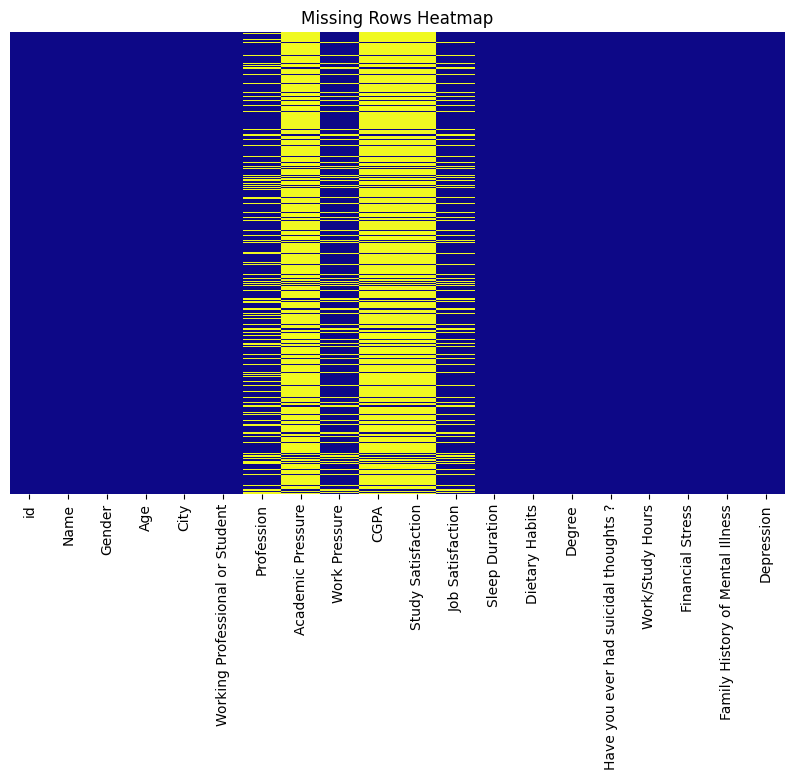

In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_train.isnull(), cbar=False, cmap="plasma", yticklabels=False)
plt.title('Missing Rows Heatmap')
plt.show()

The reason for missing rows seems to be intertwined with the "Working Professional or Student" feature. Students and working individuals have different columns assigned to themselves. This issue can be worked around with simple feature engineering.

Let'see how pressure and satisfaction contribute to depression in both cases.

Text(0.5, 1.0, 'Depression among students (%)')

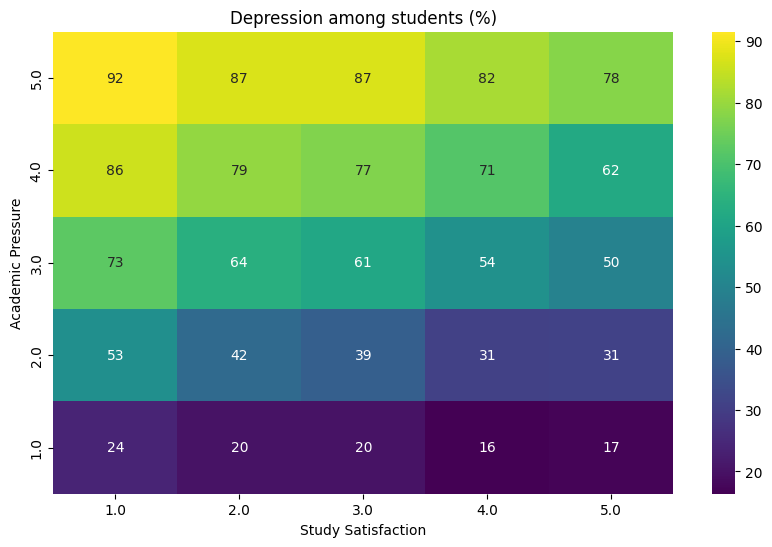

In [6]:
def percentage(col):
    total = len(col)
    count = col.sum()
    return (count / total) * 100 if total > 0 else 0

student_ps = df_train.pivot_table(
    index='Academic Pressure',  
    columns= 'Study Satisfaction',  
    values='Depression',
    aggfunc=percentage, 
    fill_value=0
)


plt.figure(figsize=(10, 6))
sns.heatmap(student_ps, annot=True, cmap="viridis", cbar=True).invert_yaxis()
plt.title('Depression among students (%)')

Text(0.5, 1.0, 'Depression among employees (%)')

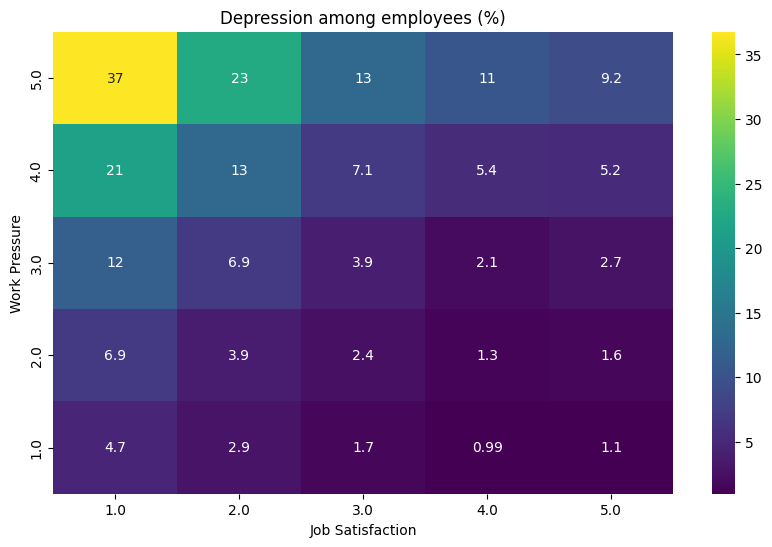

In [7]:
work_ps = df_train.pivot_table(
    index='Work Pressure',  
    columns= 'Job Satisfaction',  
    values='Depression',
    aggfunc=percentage, 
    fill_value=0
)


plt.figure(figsize=(10, 6))
sns.heatmap(work_ps, annot=True, cmap="viridis", cbar=True).invert_yaxis()
plt.title('Depression among employees (%)')

Academic pressure seems to affect students way harder than work pressure affects employees. Job satisfaction also appears to have a stronger impact on depression.

**How much info can you discern from the *Name* variable?**

*Name* variable at first glance seems to bear very little weight when it comes to predicting depressed individuals. Let's take a quick look and see if *Family History of Mental Illness* is enough and derives the same information as *Name* would.

In [8]:
top_names = (df_train.groupby('Name')
          .filter(lambda x: len(x) >= df_train["Name"].value_counts().median()/2)
          .groupby(['Name', 'Family History of Mental Illness'])['Depression']
          .mean()
          .mul(100)
          .sort_values(ascending=False)
          .head(10)
          .reset_index(name='Depression prevalence'))

print(top_names)

      Name Family History of Mental Illness  Depression prevalence
0  Shanaya                              Yes              55.000000
1     Arya                              Yes              52.205882
2   Bhavna                               No              51.724138
3    Aryan                              Yes              51.234568
4     Arya                               No              47.058824
5  Ranveer                               No              45.569620
6  Nirvaan                              Yes              43.200000
7  Nirvaan                               No              42.452830
8  Jasmine                              Yes              41.304348
9    Ishan                              Yes              40.317460


It becomes apparent that some Names have a higher prevalance for depression than others. *Family History of Mental Illness* clearly gives a boost to those percentages, but even without any history it is more likely that some names belong to depressed individuals.

Many of categorical variables contain significant clutter - there are multiple unique values with very low total counts. To combat this issue a function will be used to change values below a certain threshold.

In [9]:
def low_counts_filter(df, column, cutoff):
    
    value_counts = df[column].value_counts()

    low_count_v = value_counts[value_counts < cutoff].index

    df[column] = df[column].apply(lambda x: "Other" if x in low_count_v else x)

    return df



def feature_prep(df):   
    #Caluclating missing values per row
    df['MissingValuesCount'] = df.isna().sum(axis=1)
    
    #Addressing Cities with lower count
    df = low_counts_filter(df, 'City', df['City'].value_counts().mean())

    #Filtering out names that have very low counts
    df = low_counts_filter(df, 'Name', df['Name'].value_counts().median()/2)

    #Filtering low count Professions
    df = low_counts_filter(df, 'Profession', df['Profession'].value_counts().mean())

    #Sleep duration has a lot of diffent values that have very low counts
    df = low_counts_filter(df, 'Sleep Duration', df['Sleep Duration'].value_counts().mean())



    #Adding ratios for Academic/Work Pressure and Satisfaction
    df.loc[df['Study Satisfaction'] > 0, 'AcadRatio'] = df['Academic Pressure'] / df['Study Satisfaction']
    df.loc[df['Job Satisfaction'] > 0, 'WorkRatio'] = df['Work Pressure'] / df['Job Satisfaction']

    
    df.fillna(0, inplace = True)
    #Changing feature types
    cat_cols = ['Name', 'Gender', 'City', 'Working Professional or Student', 'Sleep Duration', 'Dietary Habits',
               'Degree', 'Have you ever had suicidal thoughts ?', 'Profession',
               'Family History of Mental Illness']
    df[cat_cols] = df[cat_cols].astype('str').astype('category')
    df = df.drop(['id'], axis = 1)

    for col in df.columns:
        if col not in cat_cols:
            df[col] = df[col].astype(float)


    return df

In [10]:
#Transforming both train and test data
df_train = feature_prep(df_train)
df_test = feature_prep(df_test)


X, y = df_train.drop('Depression', axis=1), df_train['Depression']

In [11]:
#Preparing catboost hyperparameter search with optuna
hyperparams = []



def objective(trial):

    if isinstance(X, pd.DataFrame): 
         cat_features = list(X.select_dtypes( 
             include='category').columns) 
    else: 
        cat_features = []
        
    # Hyperparameter suggestions
    iterations = trial.suggest_int('iterations', 300, 800)
    depth = trial.suggest_int('depth', 1,6)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    loss_function = trial.suggest_categorical('loss_function', ['Logloss'])
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-1, 1.0, log=True)
    global hyperparams


    # Stratified K-Fold cross-validation setup
    n_folds = 5
    folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_acc = []
    
    # Cross-validation loop
    for fold, (id_train, id_val) in enumerate(folds.split(X, y)):
        X_train, y_train = X.iloc[id_train], y.iloc[id_train]
        X_val, y_val = X.iloc[id_val], y.iloc[id_val]
        
        # Initialize and train the model
        model = CatBoostClassifier(iterations=iterations,
                                     depth=depth,
                                     learning_rate = learning_rate,
                                     loss_function = loss_function,
                                     random_state=42,
                                     l2_leaf_reg = l2_leaf_reg,
                                     task_type = 'GPU',
                                     random_strength = 0,
                                     verbose = 0)

        
        model.fit(X_train, y_train, cat_features = cat_features)
        
        # Evaluate on the validation set
        val_pred = model.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        fold_acc.append(val_acc)
    
    # Calculate mean acc across folds
    mean_acc = np.mean(fold_acc)


    hyperparams.append({
        'iterations':iterations,
        'depth':depth,
        'learning_rate': learning_rate,
        'loss_function': loss_function,
        'l2_leaf_reg': l2_leaf_reg,
        'Accuracy':mean_acc
    })

    return mean_acc


#Creating an optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2024-12-05 01:58:41,507] A new study created in memory with name: no-name-7dd0aa12-106b-4242-9726-e2463fc18089
[I 2024-12-05 01:59:54,532] Trial 0 finished with value: 0.9389623312011371 and parameters: {'iterations': 575, 'depth': 4, 'learning_rate': 0.02649283722200383, 'loss_function': 'Logloss', 'l2_leaf_reg': 0.24163522394510747}. Best is trial 0 with value: 0.9389623312011371.
[I 2024-12-05 02:00:42,756] Trial 1 finished with value: 0.9395948827292111 and parameters: {'iterations': 772, 'depth': 3, 'learning_rate': 0.053105489598184875, 'loss_function': 'Logloss', 'l2_leaf_reg': 0.4510305085346785}. Best is trial 1 with value: 0.9395948827292111.
[I 2024-12-05 02:01:05,339] Trial 2 finished with value: 0.9381094527363185 and parameters: {'iterations': 467, 'depth': 2, 'learning_rate': 0.03836437420264271, 'loss_function': 'Logloss', 'l2_leaf_reg': 0.6015082558789162}. Best is trial 1 with value: 0.9395948827292111.
[I 2024-12-05 02:02:20,152] Trial 3 finished with value: 0.939

In [12]:
# Sorting results by mean Accuracy
sorted_hyperparams = sorted(hyperparams, key=lambda x: x['Accuracy'], reverse=True)


#Removing 'Accuracy' key from all dictionaries
for params in sorted_hyperparams:
    params.pop('Accuracy', None)

best_five_hyperparams = sorted_hyperparams[0:5]

In [13]:
best_five_hyperparams

[{'iterations': 772,
  'depth': 3,
  'learning_rate': 0.053105489598184875,
  'loss_function': 'Logloss',
  'l2_leaf_reg': 0.4510305085346785},
 {'iterations': 480,
  'depth': 2,
  'learning_rate': 0.12652781391674084,
  'loss_function': 'Logloss',
  'l2_leaf_reg': 0.16446799352372407},
 {'iterations': 739,
  'depth': 5,
  'learning_rate': 0.020925350677322214,
  'loss_function': 'Logloss',
  'l2_leaf_reg': 0.4431437326360724},
 {'iterations': 575,
  'depth': 4,
  'learning_rate': 0.02649283722200383,
  'loss_function': 'Logloss',
  'l2_leaf_reg': 0.24163522394510747},
 {'iterations': 467,
  'depth': 2,
  'learning_rate': 0.03836437420264271,
  'loss_function': 'Logloss',
  'l2_leaf_reg': 0.6015082558789162}]

# Shapley values and feature importance based on a quick catboost

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


if isinstance(X, pd.DataFrame): 
         cat_features = list(X.select_dtypes( 
             include='category').columns) 
else: 
        cat_features = []

#Model on training data
model = CatBoostClassifier(
        iterations = 707,
        depth = 5,
        learning_rate = 0.09741988775458753,
        loss_function = 'Logloss',
        l2_leaf_reg = 0.13673253191571325,
        task_type = 'GPU',
        random_state=42,
        random_strength = 0,
        verbose = 0,
        cat_features=cat_features)




model.fit(X_train, y_train, cat_features = cat_features)

In [15]:
shap.initjs()
explainer = shap.TreeExplainer(model)

In [16]:
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_features))

In [17]:
shap.force_plot(explainer.expected_value, shap_values[42,:], X_train.iloc[42,:])

In [18]:
shap.force_plot(explainer.expected_value, shap_values[24,:], X_train.iloc[24,:])

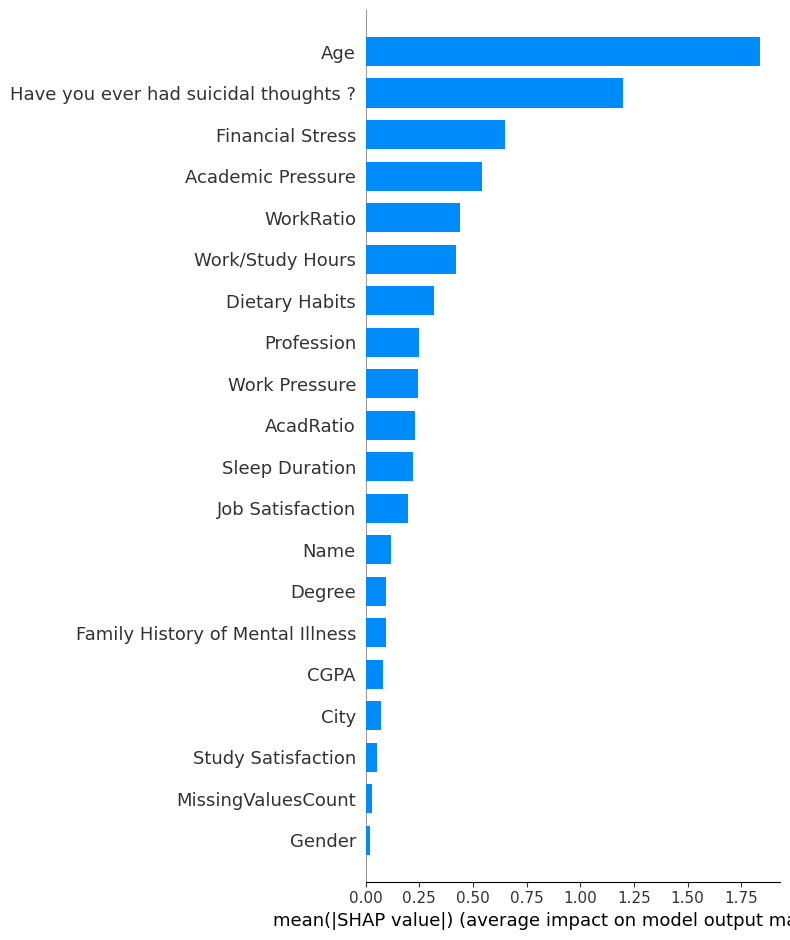

In [19]:
#Feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

Age, finances and professional pressure seem to achieve highest Shapley values.*Working Professional or Student* scored very low, which might be explained by other features carrying all connected information.

**Backwards sequential feature selection**

In [20]:
train_pool = Pool(X_train, y_train, feature_names = X_train.columns.tolist(), cat_features=cat_features)
test_pool = Pool(X_test, y_test, feature_names = X_test.columns.tolist(), cat_features=cat_features)

params = best_five_hyperparams[0]
model = CatBoostClassifier(**params,
        #iterations = 707,
        #depth = 5,
        #learning_rate = 0.09741988775458753,
        #loss_function = 'Logloss',
        #l2_leaf_reg = 0.13673253191571325,
        task_type = 'GPU',
        random_state=42,
        random_strength = 0,
        verbose = 0,
        cat_features=cat_features)

summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-19',
    num_features_to_select=18,
    steps=2,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=False
)

In [21]:
summary

{'selected_features': [0,
  2,
  3,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19],
 'eliminated_features_names': ['Gender', 'Working Professional or Student'],
 'loss_graph': {'main_indices': [0, 1, 2],
  'removed_features_count': [0, 1, 2],
  'loss_values': [0.14766097377763235,
   0.14768298028870938,
   0.14767897266650706]},
 'eliminated_features': [1, 4],
 'selected_features_names': ['Name',
  'Age',
  'City',
  'Profession',
  'Academic Pressure',
  'Work Pressure',
  'CGPA',
  'Study Satisfaction',
  'Job Satisfaction',
  'Sleep Duration',
  'Dietary Habits',
  'Degree',
  'Have you ever had suicidal thoughts ?',
  'Work/Study Hours',
  'Financial Stress',
  'Family History of Mental Illness',
  'MissingValuesCount',
  'AcadRatio']}

Checking again if removing these 2 features might improve accuracy and/or drastically change hyperparameter setup.

In [22]:
hyperparams = []

X_copy = X.drop(['Gender', 'Working Professional or Student'], axis = 1)

def objective(trial):

    if isinstance(X_copy, pd.DataFrame): 
         cat_features = list(X_copy.select_dtypes( 
             include='category').columns) 
    else: 
        cat_features = []
        
    # Hyperparameter suggestions
    iterations = trial.suggest_int('iterations', 300, 900)
    depth = trial.suggest_int('depth', 1,8)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    loss_function = trial.suggest_categorical('loss_function', ['Logloss'])
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-1, 1.0, log=True)
    global hyperparams


    # Stratified K-Fold cross-validation setup
    n_folds = 5
    folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_acc = []
    
    # Cross-validation loop
    for fold, (id_train, id_val) in enumerate(folds.split(X_copy, y)):
        X_train, y_train = X_copy.iloc[id_train], y.iloc[id_train]
        X_val, y_val = X_copy.iloc[id_val], y.iloc[id_val]
        
        # Initialize and train the model
        model = CatBoostClassifier(iterations=iterations,
                                     depth=depth,
                                     learning_rate = learning_rate,
                                     loss_function = loss_function,
                                     random_state=42,
                                     l2_leaf_reg = l2_leaf_reg,
                                     task_type = 'GPU',
                                     random_strength = 0,
                                     verbose = 0)

        
        model.fit(X_train, y_train, cat_features = cat_features)
        
        # Evaluate on the validation set
        val_pred = model.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        fold_acc.append(val_acc)
    
    # Calculate mean acc across folds
    mean_acc = np.mean(fold_acc)


    hyperparams.append({
        'iterations':iterations,
        'depth':depth,
        'learning_rate': learning_rate,
        'loss_function': loss_function,
        'l2_leaf_reg': l2_leaf_reg,
        'Accuracy':mean_acc
    })

    return mean_acc


#Creating an optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2024-12-05 02:03:37,971] A new study created in memory with name: no-name-432c1d45-bebd-4281-9fb4-bfac57b5113c
[I 2024-12-05 02:05:07,320] Trial 0 finished with value: 0.9396375266524519 and parameters: {'iterations': 867, 'depth': 5, 'learning_rate': 0.1120800279786262, 'loss_function': 'Logloss', 'l2_leaf_reg': 0.22895622814162842}. Best is trial 0 with value: 0.9396375266524519.
[I 2024-12-05 02:07:02,859] Trial 1 finished with value: 0.9370717839374556 and parameters: {'iterations': 697, 'depth': 7, 'learning_rate': 0.20309162895018848, 'loss_function': 'Logloss', 'l2_leaf_reg': 0.10927142950040739}. Best is trial 0 with value: 0.9396375266524519.
[I 2024-12-05 02:07:58,514] Trial 2 finished with value: 0.9376901208244492 and parameters: {'iterations': 324, 'depth': 7, 'learning_rate': 0.2653981300975276, 'loss_function': 'Logloss', 'l2_leaf_reg': 0.26262965160747337}. Best is trial 0 with value: 0.9396375266524519.
[I 2024-12-05 02:09:04,833] Trial 3 finished with value: 0.9375

In [23]:
# Sorting results by mean Accuracy
sorted_hyperparams_cut = sorted(hyperparams, key=lambda x: x['Accuracy'], reverse=True)


#Removing 'Accuracy' key from all dictionaries
for params in sorted_hyperparams_cut:
    params.pop('Accuracy', None)

best_five_hyperparams_cut = sorted_hyperparams_cut[0:5]


best_five_hyperparams_cut

[{'iterations': 867,
  'depth': 5,
  'learning_rate': 0.1120800279786262,
  'loss_function': 'Logloss',
  'l2_leaf_reg': 0.22895622814162842},
 {'iterations': 324,
  'depth': 7,
  'learning_rate': 0.2653981300975276,
  'loss_function': 'Logloss',
  'l2_leaf_reg': 0.26262965160747337},
 {'iterations': 390,
  'depth': 7,
  'learning_rate': 0.24328800519676697,
  'loss_function': 'Logloss',
  'l2_leaf_reg': 0.4744164802086702},
 {'iterations': 697,
  'depth': 7,
  'learning_rate': 0.20309162895018848,
  'loss_function': 'Logloss',
  'l2_leaf_reg': 0.10927142950040739},
 {'iterations': 355,
  'depth': 1,
  'learning_rate': 0.022037892205967653,
  'loss_function': 'Logloss',
  'l2_leaf_reg': 0.6244283768734183}]

# Final predictions - blending models

In [24]:
if isinstance(X_copy, pd.DataFrame): 
         cat_features = list(X_copy.select_dtypes( 
             include='category').columns) 
else: 
        cat_features = []


df_test_copy = df_test.drop(['Gender', 'Working Professional or Student'], axis = 1)

params_cut = best_five_hyperparams_cut[0]

#Model on training data
model = CatBoostClassifier(**params_cut,
        #iterations = 827,
        #depth = 2,
        #learning_rate = 0.12862427769510398,
        #loss_function = 'Logloss',
        #l2_leaf_reg = 0.3016194569671619,
        task_type = 'GPU',
        random_state=42,
        random_strength = 0,
        verbose = 0,
        cat_features=cat_features)


model.fit(X_copy, y, cat_features = cat_features)

cut_preds = model.predict_proba(df_test_copy)[:, 1]


if isinstance(X, pd.DataFrame): 
         cat_features = list(X.select_dtypes( 
             include='category').columns) 
else: 
        cat_features = []

#Model on training data
model = CatBoostClassifier(**params,
        #iterations = 785,
        #depth = 5,
        #learning_rate = 0.09211596149787475,
        #loss_function = 'Logloss',
        #l2_leaf_reg = 0.12581454394877276,
        task_type = 'GPU',
        random_state=42,
        random_strength = 0,
        verbose = 0,
        cat_features=cat_features)


model.fit(X, y, cat_features = cat_features)

preds = model.predict_proba(df_test)[:, 1]

In [25]:
#Joining probabilities
pred_blend = (preds+cut_preds)/2
final_pred = (pred_blend > 0.5).astype(int)

In [26]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')

In [27]:
sample_submission['Depression'] = final_pred
sample_submission.to_csv("submission.csv", index = False)